In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [159]:
data_desc = pd.read_csv('E:\My_projects\gene_embeddings__descriptors.csv').reset_index(drop=True)

import json
with open("E:\My_projects\gene_mistral_common.json", "r") as f:
    embeddings_data = json.load(f)

# Извлечение эмбеддингов
data = []
for item in embeddings_data:
    input_value = item['input']
    embedding_values = item['embedding']

    # Разбиваем embedding на отдельные значения
    embedding_list = []  # Создаем пустой список для значений эмбеддинга
    for value in embedding_values:  # Итерируем по элементам списка embedding_values
        embedding_list.append(float(value))  # Добавляем значения в список embedding_list

    # Создаем словарь для записи в DataFrame
    row_data = {'gene_sequence': input_value}
    for i, value in enumerate(embedding_list):
        row_data[f'embedding_{i+1}'] = value  # Добавляем значения в словарь row_data

    data.append(row_data)

# Создаем DataFrame
embs = pd.DataFrame(data)
embs

# Задаём имя колонки с генами
gene_column = 'gene_sequence'

# Проверяем наличие столбца gene в обоих датафреймах
if gene_column not in data_desc.columns:
    raise ValueError(f"Столбец '{gene_column}' не найден в первом датафрейме.")
if gene_column not in embs.columns:
    raise ValueError(f"Столбец '{gene_column}' не найден во втором датафрейме.")

# Проверяем уникальность столбца gene во втором датафрейме
if not embs[gene_column].is_unique:
    raise ValueError(f"Столбец '{gene_column}' во втором датафрейме не уникален. Убедитесь, что каждому значению гена соответствует только один набор эмбеддингов.")


# Слияние датафреймов по столбцу gene
merged_df = pd.merge(data_desc, embs, on=gene_column, how='left')

# Проверка на наличие NaN значений
if merged_df.isnull().any().any():
     na_count = merged_df.isnull().sum().sum()
     print(f"Предупреждение: {na_count} значения NaN были обнаружены в объединенном датасете. Проверьте, все ли значения генов из data1.csv присутствуют в data2.csv.")

def remove_trailing_period(value):
    if isinstance(value, str) and value.endswith('.'):
        return value[:-1]
    return value
merged_df['Concentration, nM'] = merged_df['Concentration, nM'].apply(remove_trailing_period).astype(float)
merged_df = merged_df[merged_df['Concentration, nM'] <= 100]
merged_df = merged_df.iloc[:2600]
X = merged_df
y = X['Efficacy, %']
X = X.drop(columns=['Efficacy, %', 'siRNA concentration', 'Unnamed: 0',	'SMDBid', 'Target gene', 'gene_sequence'])
X

X = X.rename(columns={'Concentration, nM': 'Concentration_nM', 'Cell or Organism used': 'Cell_or_Organism_used', 'Transfection method': 'Transfection_method', 
                      'Experiment used to check activity': 'Experiment_used_to_check_activity', 'Duration after transfection': 'Duration_after_transfection'})

conc = X['Concentration_nM']
cell = X['Cell_or_Organism_used']
transf = X['Transfection_method']
exper = X['Experiment_used_to_check_activity']
dura = X['Duration_after_transfection']

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
C:\Users\ivang\AppData\Local\Temp\ipykernel_12744\1183953224.py:1: SyntaxWarning: invalid escape sequence '\M'
  data_desc = pd.read_csv('E:\My_projects\gene_embeddings__descriptors.csv').reset_index(drop=True)
C:\Users\ivang\AppData\Local\Temp\ipykernel_12744\1183953224.py:4: SyntaxWarning: invalid escape sequence '\M'
  with open("E:\My_projects\gene_mistral_common.json", "r") as f:
C:\Users\ivang\AppData\Local\Temp\ipykernel_12744\1183953224.py:1: DtypeWarning: Columns (2324) have mixed types. Specify dtype option on import or set low_memory=False.
  data_desc = pd.read_csv('E:\My_projects\gene_embeddings__descriptors.csv').reset_index(drop=True)


In [160]:
print(X.shape)

(2600, 6423)


In [161]:
y

0       40.77
1       42.17
2       44.11
3       65.16
4       60.40
        ...  
2599    74.00
2600    82.00
2601    22.00
2602    70.00
2603    82.00
Name: Efficacy, %, Length: 2600, dtype: float64

In [162]:
def categorize_value(value):
  if value <= 51:
    return 1
  elif 52 <= value:
    return 2
  else:
    return 1
y = y.iloc[:2600]
y_binary = y.apply(categorize_value)

In [163]:
y_binary.value_counts()

Efficacy, %
2    1645
1     955
Name: count, dtype: int64

In [164]:
X = X.iloc[:2600]

In [165]:
def select_uncorrelated_features(model, X_train, X, correlation_threshold=0.95, top_n=100):
    """
    Выбирает наиболее важные признаки на основе feature_importances модели и исключает высококоррелирующие признаки.

    Args:
        model: Обученная модель с атрибутом feature_importances_.
        X_train: Датафрейм, использованный для обучения модели (используется для получения имен признаков).
        X: Исходный датафрейм со всеми признаками (из которого будут выбираться некоррелирующие признаки).
        correlation_threshold: Пороговое значение корреляции для исключения признаков (по умолчанию 0.95).
        top_n: Количество наиболее важных признаков для рассмотрения (по умолчанию 100).

    Returns:
        Список имен некоррелирующих признаков.
    """

    feature_importances = model.feature_importances_

    # Создание списка кортежей (значение важности, имя признака)
    top_features = sorted(zip(feature_importances, X_train.columns), key=lambda x: x[0], reverse=True)[:top_n]

    # Извлечение имен топовых признаков
    top_features_names = [feature[1] for feature in top_features]

    # Фильтрация датафрейма по топовым признакам
    X_top = X[top_features_names]

    # Вычисление матрицы корреляции
    corr_matrix = X_top.corr().abs()

    # Выбор верхнего треугольника матрицы корреляции
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Поиск индексов колонок с корреляцией больше correlation_threshold
    high_cor = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

    # Исключение высококоррелирующих фич из списка топовых фич
    features = [i for i in top_features_names if i not in high_cor]

    return features

In [166]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import optuna

def objective(trial, X_train, y_train, X_valid, y_valid):
    params = {
        'objective': 'binary',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0), 
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    # Используйте метрику, которая лучше всего подходит для вашей задачи
    accuracy = accuracy_score(y_valid, y_pred)

    return 1 - accuracy 

In [167]:
def data_prep(X, y):
    X_scaled = X.copy()
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

from sklearn.metrics import classification_report
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
def cross_val_score1(X, y, X_test, y_test, predction_dataframe, test_predction_dataframe, cv=10):
    kf = KFold(n_splits=cv, shuffle=True, random_state=256)
    model = lgb.LGBMClassifier()
    
    X = X.copy()
    y = y.copy().apply(categorize_value)
    y_test = y_test.copy().apply(categorize_value)
    new_X = X.copy()
    counter = 0
    for train_index, valid_index in kf.split(X):
        counter +=1
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        model.fit(X_train, y_train)
        features = select_uncorrelated_features(model, X_train, X)

        X_train = X_train[features]
        X_valid = X_valid[features]
        X_train.loc[:,'Concentration_nM'] = X.loc[X.index.intersection(X_train.index), 'Concentration_nM']
        X_valid.loc[:,'Concentration_nM'] = X.loc[X.index.intersection(X_valid.index), 'Concentration_nM']
        X_train.loc[:,'Cell_or_Organism_used'] = X.loc[X.index.intersection(X_train.index), 'Cell_or_Organism_used']
        X_valid.loc[:,'Cell_or_Organism_used'] = X.loc[X.index.intersection(X_valid.index), 'Cell_or_Organism_used']
        X_train.loc[:,'Transfection_method'] = X.loc[X.index.intersection(X_train.index), 'Transfection_method']
        X_valid.loc[:,'Transfection_method'] = X.loc[X.index.intersection(X_valid.index), 'Transfection_method']
        X_train.loc[:,'Experiment_used_to_check_activity'] = X.loc[X.index.intersection(X_train.index), 'Experiment_used_to_check_activity']
        X_valid.loc[:,'Experiment_used_to_check_activity'] = X.loc[X.index.intersection(X_valid.index), 'Experiment_used_to_check_activity']
        X_train.loc[:,'Duration_after_transfection'] = X.loc[X.index.intersection(X_train.index), 'Duration_after_transfection']
        X_valid.loc[:,'Duration_after_transfection'] = X.loc[X.index.intersection(X_valid.index), 'Duration_after_transfection']
        print(X_train.shape, X_valid.shape, X_test.shape)
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=100)  # Количество испытаний
        best_params = study.best_params

        model = lgb.LGBMClassifier(**best_params)
        model.fit(X_train, y_train)

        y_pred_proba = model.predict_proba(X_valid)
        y_pred_proba_test = model.predict_proba(X_test[X_train.columns])

        for i in range(y_pred_proba.shape[1]):
            col_name = f'split_proba_class_{i + 1}'
    # Create a Series with the predictions, indexed by the original indices
            proba_series = pd.Series(y_pred_proba[:, i], index=X_valid.index)

    # Assign the probabilities to the corresponding rows in X
            new_X.loc[X_valid.index, col_name] = proba_series
        
        for i in range(y_pred_proba_test.shape[1]):
            col_name = f'{counter}_split_proba_class_{i + 1}'
            test_predction_dataframe[col_name] = y_pred_proba_test[:, i]

                #predction_dataframe.loc[X_valid_fold.index, col_name] = pd.Series(y_pred_proba[:, i], index=X_valid_fold.index)


    return predction_dataframe, test_predction_dataframe, new_X


In [168]:
predction_dataframe = pd.DataFrame()
test_predction_dataframe = pd.DataFrame()
X, X_test, y, y_test = data_prep(X, y)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)


In [169]:
predction_dataframe, test_predction_dataframe, X = cross_val_score1(X, y, X_test, y_test, predction_dataframe, test_predction_dataframe)
split_proba_class_1 = X['split_proba_class_1']
split_proba_class_2 = X['split_proba_class_2']

[LightGBM] [Info] Number of positive: 1184, number of negative: 688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84443
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 6210
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.632479 -> initscore=0.542865
[LightGBM] [Info] Start training from score 0.542865


[I 2025-02-20 19:34:21,602] A new study created in memory with name: no-name-ee472caf-d348-4ddb-b1ab-5a5fecb36214


(1872, 72) (208, 72) (520, 6423)


[I 2025-02-20 19:34:22,308] Trial 0 finished with value: 0.12019230769230771 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'learning_rate': 0.24908759613680853, 'n_estimators': 517, 'max_depth': 9, 'subsample': 0.8942349605929663, 'colsample_bytree': 0.5994492806609675, 'reg_alpha': 0.46202540620428934, 'reg_lambda': 0.7584294325576807}. Best is trial 0 with value: 0.12019230769230771.
[I 2025-02-20 19:34:22,578] Trial 1 finished with value: 0.15384615384615385 and parameters: {'boosting_type': 'goss', 'num_leaves': 126, 'learning_rate': 0.25058386964263846, 'n_estimators': 779, 'max_depth': 8, 'subsample': 0.6461322579448695, 'colsample_bytree': 0.6131555653781797, 'reg_alpha': 0.176700881633843, 'reg_lambda': 0.45205920769160934}. Best is trial 0 with value: 0.12019230769230771.
[I 2025-02-20 19:34:22,597] Trial 2 finished with value: 0.1875 and parameters: {'boosting_type': 'goss', 'num_leaves': 61, 'learning_rate': 0.08534891587442743, 'n_estimators': 11, 'max_depth':

[LightGBM] [Info] Number of positive: 1184, number of negative: 688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1220
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.632479 -> initscore=0.542865
[LightGBM] [Info] Start training from score 0.542865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-02-20 19:35:31,562] A new study created in memory with name: no-name-abbb4373-e40a-43c7-bce6-70ef267493cc
[I 2025-02-20 19:35:31,596] Trial 0 finished with value: 0.13942307692307687 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'learning_rate': 0.4524226773480241, 'n_estimators': 97, 'max_depth': 5, 'subsample': 0.9377831851106233, 'colsample_bytree': 0.5763968558473418, 'reg_alpha': 0.14107822351924693, 'reg_lambda': 0.7339026598183999}. Best is trial 0 with value: 0.13942307692307687.


(1872, 66) (208, 66) (520, 6423)


[I 2025-02-20 19:35:31,863] Trial 1 finished with value: 0.17788461538461542 and parameters: {'boosting_type': 'goss', 'num_leaves': 83, 'learning_rate': 0.3768757932285117, 'n_estimators': 774, 'max_depth': 7, 'subsample': 0.8885043970628778, 'colsample_bytree': 0.5145619296092525, 'reg_alpha': 0.3128116086703202, 'reg_lambda': 0.9999288681636395}. Best is trial 0 with value: 0.13942307692307687.
[I 2025-02-20 19:35:31,922] Trial 2 finished with value: 0.13461538461538458 and parameters: {'boosting_type': 'goss', 'num_leaves': 72, 'learning_rate': 0.23500246351992393, 'n_estimators': 393, 'max_depth': 1, 'subsample': 0.6256642572583992, 'colsample_bytree': 0.5655755142632177, 'reg_alpha': 0.7609227270656288, 'reg_lambda': 0.031205004290704386}. Best is trial 2 with value: 0.13461538461538458.
[I 2025-02-20 19:35:32,037] Trial 3 finished with value: 0.125 and parameters: {'boosting_type': 'goss', 'num_leaves': 14, 'learning_rate': 0.07285162583626076, 'n_estimators': 294, 'max_depth': 

[LightGBM] [Info] Number of positive: 1184, number of negative: 688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1129
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.632479 -> initscore=0.542865
[LightGBM] [Info] Start training from score 0.542865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-02-20 19:36:10,851] A new study created in memory with name: no-name-253b429a-8a0d-4500-ad0a-c69756cc8fbc


(1872, 77) (208, 77) (520, 6423)


[I 2025-02-20 19:36:11,067] Trial 0 finished with value: 0.16826923076923073 and parameters: {'boosting_type': 'goss', 'num_leaves': 99, 'learning_rate': 0.3221865919084964, 'n_estimators': 768, 'max_depth': -1, 'subsample': 0.5665676497457415, 'colsample_bytree': 0.7835761342295786, 'reg_alpha': 0.8516334638422044, 'reg_lambda': 0.30495484773575365}. Best is trial 0 with value: 0.16826923076923073.
[I 2025-02-20 19:36:11,157] Trial 1 finished with value: 0.16346153846153844 and parameters: {'boosting_type': 'goss', 'num_leaves': 12, 'learning_rate': 0.18389295324360186, 'n_estimators': 281, 'max_depth': 10, 'subsample': 0.8012453243972643, 'colsample_bytree': 0.937750902864739, 'reg_alpha': 0.890363313065791, 'reg_lambda': 0.48186520733283267}. Best is trial 1 with value: 0.16346153846153844.
[I 2025-02-20 19:36:11,399] Trial 2 finished with value: 0.16826923076923073 and parameters: {'boosting_type': 'goss', 'num_leaves': 249, 'learning_rate': 0.08618083342042024, 'n_estimators': 665

[LightGBM] [Info] Number of positive: 1192, number of negative: 680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.636752 -> initscore=0.561295
[LightGBM] [Info] Start training from score 0.561295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-02-20 19:36:49,779] A new study created in memory with name: no-name-6882413c-3bba-404b-a99d-5058d08c623d
[I 2025-02-20 19:36:49,845] Trial 0 finished with value: 0.16346153846153844 and parameters: {'boosting_type': 'goss', 'num_leaves': 212, 'learning_rate': 0.1357489371448953, 'n_estimators': 286, 'max_depth': 3, 'subsample': 0.6735772699142876, 'colsample_bytree': 0.51490352017284, 'reg_alpha': 0.9119305006947818, 'reg_lambda': 0.44250889680221384}. Best is trial 0 with value: 0.16346153846153844.
[I 2025-02-20 19:36:49,865] Trial 1 finished with value: 0.16346153846153844 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.21924754511794464, 'n_estimators': 90, 'max_depth': 2, 'subsample': 0.6395887902213558, 'colsample_bytree': 0.9191453661624598, 'reg_alpha': 0.18146544597384096, 'reg_lambda': 0.4398663171891253}. Best is trial 0 with value: 0.16346153846153844.
[I 2025-02-20 19:36:49,919] Trial 2 finished with value: 0.15384615384615385 and pa

(1872, 71) (208, 71) (520, 6423)


[I 2025-02-20 19:36:50,023] Trial 3 finished with value: 0.1298076923076923 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'learning_rate': 0.43445143053505675, 'n_estimators': 789, 'max_depth': 5, 'subsample': 0.6731734676801788, 'colsample_bytree': 0.5718142318718911, 'reg_alpha': 0.5685729713458498, 'reg_lambda': 0.8870762780427257}. Best is trial 3 with value: 0.1298076923076923.
[I 2025-02-20 19:36:50,093] Trial 4 finished with value: 0.1875 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'learning_rate': 0.056610252394277416, 'n_estimators': 659, 'max_depth': 1, 'subsample': 0.623407595359448, 'colsample_bytree': 0.5295171697653073, 'reg_alpha': 0.28458321046626067, 'reg_lambda': 0.9493060253320028}. Best is trial 3 with value: 0.1298076923076923.
[I 2025-02-20 19:36:50,921] Trial 5 finished with value: 0.13461538461538458 and parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'learning_rate': 0.0804646178442954, 'n_estimators': 536, 'max_depth': 

[LightGBM] [Info] Number of positive: 1190, number of negative: 682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1237
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.635684 -> initscore=0.556679
[LightGBM] [Info] Start training from score 0.556679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-02-20 19:37:20,549] A new study created in memory with name: no-name-1f3b4c6f-c5f4-4bd0-ab2b-ff439de509d7


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-02-20 19:37:20,812] Trial 0 finished with value: 0.17788461538461542 and parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'learning_rate': 0.3899389798362306, 'n_estimators': 885, 'max_depth': 1, 'subsample': 0.905165591997664, 'colsample_bytree': 0.7224689235878947, 'reg_alpha': 0.6222555798181831, 'reg_lambda': 0.34005730356132524}. Best is trial 0 with value: 0.17788461538461542.
[I 2025-02-20 19:37:22,598] Trial 1 finished with value: 0.11538461538461542 and parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'learning_rate': 0.078325032135546, 'n_estimators': 957, 'max_depth': 9, 'subsample': 0.6908841604748126, 'colsample_bytree': 0.5022481284598502, 'reg_alpha': 0.8476492080162966, 'reg_lambda': 0.3916765790687228}. Best is trial 1 with value: 0.11538461538461542.
[I 2025-02-20 19:37:22,664] Trial 2 finished with value: 0.1826923076923077 and parameters: {'boosting_type': 'goss', 'num_leaves': 250, 'learning_rate': 0.08504182509430051, 'n_estimators': 393, 'm

[LightGBM] [Info] Number of positive: 1191, number of negative: 681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.636218 -> initscore=0.558986
[LightGBM] [Info] Start training from score 0.558986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-02-20 19:37:51,877] A new study created in memory with name: no-name-d2b1b0f4-f1ce-40cd-9c11-e9537b4f9623


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
(1872, 68) (208, 68) (520, 6423)


[I 2025-02-20 19:37:51,938] Trial 0 finished with value: 0.14903846153846156 and parameters: {'boosting_type': 'goss', 'num_leaves': 24, 'learning_rate': 0.391420540310233, 'n_estimators': 179, 'max_depth': 6, 'subsample': 0.6826518635944667, 'colsample_bytree': 0.8998337409603381, 'reg_alpha': 0.8961128945451666, 'reg_lambda': 0.9886923842820441}. Best is trial 0 with value: 0.14903846153846156.
[I 2025-02-20 19:37:51,995] Trial 1 finished with value: 0.12019230769230771 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'learning_rate': 0.41215656700764375, 'n_estimators': 386, 'max_depth': 2, 'subsample': 0.9583979735899294, 'colsample_bytree': 0.743424954115503, 'reg_alpha': 0.31630867090461423, 'reg_lambda': 0.3354554977281392}. Best is trial 1 with value: 0.12019230769230771.
[I 2025-02-20 19:37:52,272] Trial 2 finished with value: 0.15384615384615385 and parameters: {'boosting_type': 'goss', 'num_leaves': 152, 'learning_rate': 0.2191905074292499, 'n_estimators': 897, '

[LightGBM] [Info] Number of positive: 1190, number of negative: 682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.635684 -> initscore=0.556679
[LightGBM] [Info] Start training from score 0.556679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-02-20 19:38:11,947] A new study created in memory with name: no-name-f2b22c15-d2cb-4aa5-9e22-a144279fe04b
[I 2025-02-20 19:38:11,973] Trial 0 finished with value: 0.2692307692307693 and parameters: {'boosting_type': 'goss', 'num_leaves': 108, 'learning_rate': 0.023948381449749763, 'n_estimators': 44, 'max_depth': 1, 'subsample': 0.5057833139917693, 'colsample_bytree': 0.5220226470886044, 'reg_alpha': 0.6009231907408511, 'reg_lambda': 0.9940346303188773}. Best is trial 0 with value: 0.2692307692307693.
[I 2025-02-20 19:38:12,069] Trial 1 finished with value: 0.1298076923076923 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'learning_rate': 0.48755523327818345, 'n_estimators': 308, 'max_depth': 7, 'subsample': 0.7447020550605277, 'colsample_bytree': 0.6300156284997598, 'reg_alpha': 0.3018764933212399, 'reg_lambda': 0.515845876651863}. Best is trial 1 with value: 0.1298076923076923.


(1872, 74) (208, 74) (520, 6423)


[I 2025-02-20 19:38:12,376] Trial 2 finished with value: 0.11538461538461542 and parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'learning_rate': 0.380594082936074, 'n_estimators': 322, 'max_depth': 7, 'subsample': 0.8230803523656441, 'colsample_bytree': 0.6068683138637387, 'reg_alpha': 0.8806439963010734, 'reg_lambda': 0.24414575140292416}. Best is trial 2 with value: 0.11538461538461542.
[I 2025-02-20 19:38:12,501] Trial 3 finished with value: 0.13461538461538458 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'learning_rate': 0.41103598369212097, 'n_estimators': 535, 'max_depth': 4, 'subsample': 0.9909083751095465, 'colsample_bytree': 0.6476733385846679, 'reg_alpha': 0.12204058062466161, 'reg_lambda': 0.08459405572445666}. Best is trial 2 with value: 0.11538461538461542.
[I 2025-02-20 19:38:12,518] Trial 4 finished with value: 0.13461538461538458 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'learning_rate': 0.4313026231813259, 'n_estimators': 14,

[LightGBM] [Info] Number of positive: 1174, number of negative: 698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1237
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.627137 -> initscore=0.519953
[LightGBM] [Info] Start training from score 0.519953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-02-20 19:38:30,119] A new study created in memory with name: no-name-8a092a50-9d8b-46e9-983f-cf75d708ba72


(1872, 63) (208, 63) (520, 6423)


[I 2025-02-20 19:38:30,427] Trial 0 finished with value: 0.11538461538461542 and parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'learning_rate': 0.2600264790989971, 'n_estimators': 475, 'max_depth': 4, 'subsample': 0.9789380292332279, 'colsample_bytree': 0.6519403147098238, 'reg_alpha': 0.6779298342056853, 'reg_lambda': 0.5785134382117076}. Best is trial 0 with value: 0.11538461538461542.
[I 2025-02-20 19:38:30,615] Trial 1 finished with value: 0.125 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'learning_rate': 0.21112006563562116, 'n_estimators': 525, 'max_depth': 2, 'subsample': 0.8923833188217152, 'colsample_bytree': 0.977681350732204, 'reg_alpha': 0.40304705064805113, 'reg_lambda': 0.14240520326620232}. Best is trial 0 with value: 0.11538461538461542.
[I 2025-02-20 19:38:30,667] Trial 2 finished with value: 0.13942307692307687 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'learning_rate': 0.49462862429217413, 'n_estimators': 203, 'max_depth': 

[LightGBM] [Info] Number of positive: 1185, number of negative: 687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.633013 -> initscore=0.545164
[LightGBM] [Info] Start training from score 0.545164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-02-20 19:38:55,239] A new study created in memory with name: no-name-08285645-b92f-4885-84e5-94c487a439d8


(1872, 69) (208, 69) (520, 6423)


[I 2025-02-20 19:38:56,637] Trial 0 finished with value: 0.10576923076923073 and parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'learning_rate': 0.015141652178597406, 'n_estimators': 894, 'max_depth': 6, 'subsample': 0.6428214387976474, 'colsample_bytree': 0.5565164968795728, 'reg_alpha': 0.7358073389726393, 'reg_lambda': 0.11925513160537626}. Best is trial 0 with value: 0.10576923076923073.
[I 2025-02-20 19:38:56,885] Trial 1 finished with value: 0.10096153846153844 and parameters: {'boosting_type': 'goss', 'num_leaves': 171, 'learning_rate': 0.3212166906464908, 'n_estimators': 648, 'max_depth': -1, 'subsample': 0.9270198121024875, 'colsample_bytree': 0.9005875557337315, 'reg_alpha': 0.20330117791658908, 'reg_lambda': 0.5295983127826117}. Best is trial 1 with value: 0.10096153846153844.
[I 2025-02-20 19:38:57,293] Trial 2 finished with value: 0.09615384615384615 and parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'learning_rate': 0.43810273060386173, 'n_estimators':

[LightGBM] [Info] Number of positive: 1174, number of negative: 698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.627137 -> initscore=0.519953
[LightGBM] [Info] Start training from score 0.519953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-02-20 19:39:59,878] A new study created in memory with name: no-name-c70a94c0-b6ad-400a-aa4d-a13dfdd54acc
[I 2025-02-20 19:39:59,980] Trial 0 finished with value: 0.11538461538461542 and parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'learning_rate': 0.46090261356921725, 'n_estimators': 226, 'max_depth': 4, 'subsample': 0.7038944408749481, 'colsample_bytree': 0.8203350023943909, 'reg_alpha': 0.40048515819883745, 'reg_lambda': 0.8304531862148455}. Best is trial 0 with value: 0.11538461538461542.


(1872, 66) (208, 66) (520, 6423)


[I 2025-02-20 19:40:00,240] Trial 1 finished with value: 0.08173076923076927 and parameters: {'boosting_type': 'goss', 'num_leaves': 87, 'learning_rate': 0.012755130713846029, 'n_estimators': 713, 'max_depth': 10, 'subsample': 0.6920671313281579, 'colsample_bytree': 0.7325351090918789, 'reg_alpha': 0.966407199706231, 'reg_lambda': 0.4478341033161123}. Best is trial 1 with value: 0.08173076923076927.
[I 2025-02-20 19:40:00,421] Trial 2 finished with value: 0.13942307692307687 and parameters: {'boosting_type': 'goss', 'num_leaves': 209, 'learning_rate': 0.2883623420345546, 'n_estimators': 520, 'max_depth': 9, 'subsample': 0.8772228533016815, 'colsample_bytree': 0.6034405801354223, 'reg_alpha': 0.038424158078398496, 'reg_lambda': 0.21859756597264457}. Best is trial 1 with value: 0.08173076923076927.
[I 2025-02-20 19:40:00,456] Trial 3 finished with value: 0.10096153846153844 and parameters: {'boosting_type': 'goss', 'num_leaves': 87, 'learning_rate': 0.48304125689187966, 'n_estimators': 8

[LightGBM] [Info] Number of positive: 1180, number of negative: 692
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630342 -> initscore=0.533684
[LightGBM] [Info] Start training from score 0.533684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [170]:
X

desc_1   desc_2  desc_3  desc_4  desc_5  desc_6  desc_7  desc_8  \
0     482.984512  483.156    17.0     8.0     8.0     7.0    13.0    29.0   
1     341.967071  342.070    11.0     4.0     7.0     4.0     7.0    19.0   
2     522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
3     522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
4     522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
...          ...      ...     ...     ...     ...     ...     ...     ...   
2075  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2076  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2077  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2078  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2079  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   

      desc_9  desc_10  ...  embedding_4089  embedding_4090  embedding_4091  \
0       45.0     20.0  ...        2.236328       -4.785156         3.78125   
1       32.0     14.0  ...        6.851562       -2.343750         2.78125   
2       48.0     22.0  ...        5.824219       -3.316406         4.65625   
3       48.0     22.0  ...        5.824219       -3.316406         4.65625   
4       48.0     22.0  ...        5.824219       -3.316406         4.65625   
...      ...      ...  ...             ...             ...             ...   
2075    48.0     22.0  ...        5.824219       -3.316406         4.65625   
2076    48.0     22.0  ...        5.824219       -3.316406         4.65625   
2077    48.0     22.0  ...        5.824219       -3.316406         4.65625   
2078    48.0     22.0  ...        5.824219       -3.316406         4.65625   
2079    48.0     22.0  ...        5.824219       -3.316406         4.65625   

      embedding_4092  embedding_4093  embedding_4094  embedding_4095  \
0           3.292969        2.785156        7.957031       -2.443359   
1           0.742188        0.783203        3.218750       -2.306641   
2           2.623047       -2.548828        6.742188       -3.642578   
3           2.623047       -2.548828        6.742188       -3.642578   
4           2.623047       -2.548828        6.742188       -3.642578   
...              ...             ...             ...             ...   
2075        2.623047       -2.548828        6.742188       -3.642578   
2076        2.623047       -2.548828        6.742188       -3.642578   
2077        2.623047       -2.548828        6.742188       -3.642578   
2078        2.623047       -2.548828        6.742188       -3.642578   
2079        2.623047       -2.548828        6.742188       -3.642578   

      embedding_4096  split_proba_class_1  split_proba_class_2  
0           0.122009             0.300438             0.699562  
1           1.617188             0.061744             0.938256  
2           2.503906             0.997646             0.002354  
3           2.503906             0.996381             0.003619  
4           2.503906             0.113827             0.886173  
...              ...                  ...                  ...  
2075        2.503906             0.000220             0.999780  
2076        2.503906             0.010910             0.989090  
2077        2.503906             0.023323             0.976677  
2078        2.503906             0.975164             0.024836  
2079        2.503906             0.600130             0.399870  

[2080 rows x 6425 columns]

In [171]:
X_test

desc_1   desc_2  desc_3  desc_4  desc_5  desc_6  desc_7  desc_8  \
0    522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
1    341.967071  342.070    11.0     4.0     7.0     4.0     7.0    19.0   
2    341.967071  342.070    11.0     4.0     7.0     4.0     7.0    19.0   
3    522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
4    522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
..          ...      ...     ...     ...     ...     ...     ...     ...   
515  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
516  341.967071  342.070    11.0     4.0     7.0     4.0     7.0    19.0   
517  506.995745  507.182    18.0     8.0     8.0     7.0    13.0    31.0   
518  341.967071  342.070    11.0     4.0     7.0     4.0     7.0    19.0   
519  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   

     desc_9  desc_10  ...  embedding_4087  embedding_4088  embedding_4089  \
0      48.0     22.0  ...        9.398438        1.862305        5.824219   
1      32.0     14.0  ...        8.851562       -0.051636        6.851562   
2      32.0     14.0  ...       10.335938        4.968750        3.476562   
3      48.0     22.0  ...        9.398438        1.862305        5.824219   
4      48.0     22.0  ...        9.398438        1.862305        5.824219   
..      ...      ...  ...             ...             ...             ...   
515    48.0     22.0  ...        9.398438        1.862305        5.824219   
516    32.0     14.0  ...       10.335938        4.968750        3.476562   
517    47.0     21.0  ...        9.398438        1.862305        5.824219   
518    32.0     14.0  ...        8.851562       -0.051636        6.851562   
519    48.0     22.0  ...        9.398438        1.862305        5.824219   

     embedding_4090  embedding_4091  embedding_4092  embedding_4093  \
0         -3.316406        4.656250        2.623047       -2.548828   
1         -2.343750        2.781250        0.742188        0.783203   
2         -5.949219        3.808594        7.660156        0.290771   
3         -3.316406        4.656250        2.623047       -2.548828   
4         -3.316406        4.656250        2.623047       -2.548828   
..              ...             ...             ...             ...   
515       -3.316406        4.656250        2.623047       -2.548828   
516       -5.949219        3.808594        7.660156        0.290771   
517       -3.316406        4.656250        2.623047       -2.548828   
518       -2.343750        2.781250        0.742188        0.783203   
519       -3.316406        4.656250        2.623047       -2.548828   

     embedding_4094  embedding_4095  embedding_4096  
0          6.742188       -3.642578        2.503906  
1          3.218750       -2.306641        1.617188  
2          8.742188       -1.713867        2.681641  
3          6.742188       -3.642578        2.503906  
4          6.742188       -3.642578        2.503906  
..              ...             ...             ...  
515        6.742188       -3.642578        2.503906  
516        8.742188       -1.713867        2.681641  
517        6.742188       -3.642578        2.503906  
518        3.218750       -2.306641        1.617188  
519        6.742188       -3.642578        2.503906  

[520 rows x 6423 columns]

In [172]:
def objective(trial, X_train, y_train, X_valid, y_valid):
    params = {
        'objective': 'multiclass',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0), 
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    # Используйте метрику, которая лучше всего подходит для вашей задачи
    accuracy = accuracy_score(y_valid, y_pred)

    return 1 - accuracy 

def categorize_value2(value):
  if 0 <= value <= 25:
    return 1
  elif 26 <= value <= 50:
    return 2
  elif 51 <= value <= 75:
    return 3
  elif 76 <= value <= 100:
    return 4
  else:
    return 1

def cross_val_score_multi(X, y, X_test, y_test, predction_dataframe, test_predction_dataframe, cv=10):
    kf = KFold(n_splits=cv, shuffle=True, random_state=256)
    model = lgb.LGBMClassifier()
    
    X = X.drop(columns=['split_proba_class_1', 'split_proba_class_2']).copy()
    y = y.copy().apply(categorize_value2)
    y_test = y_test.copy().apply(categorize_value2)
    new_X = X.copy()
    counter = 0
    for train_index, valid_index in kf.split(X):
        counter +=1
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        model.fit(X_train, y_train)
        features = select_uncorrelated_features(model, X_train, X)

        X_train = X_train[features]
        X_valid = X_valid[features]
        X_train.loc[:,'Concentration_nM'] = X.loc[X.index.intersection(X_train.index), 'Concentration_nM']
        X_valid.loc[:,'Concentration_nM'] = X.loc[X.index.intersection(X_valid.index), 'Concentration_nM']
        X_train.loc[:,'Cell_or_Organism_used'] = X.loc[X.index.intersection(X_train.index), 'Cell_or_Organism_used']
        X_valid.loc[:,'Cell_or_Organism_used'] = X.loc[X.index.intersection(X_valid.index), 'Cell_or_Organism_used']
        X_train.loc[:,'Transfection_method'] = X.loc[X.index.intersection(X_train.index), 'Transfection_method']
        X_valid.loc[:,'Transfection_method'] = X.loc[X.index.intersection(X_valid.index), 'Transfection_method']
        X_train.loc[:,'Experiment_used_to_check_activity'] = X.loc[X.index.intersection(X_train.index), 'Experiment_used_to_check_activity']
        X_valid.loc[:,'Experiment_used_to_check_activity'] = X.loc[X.index.intersection(X_valid.index), 'Experiment_used_to_check_activity']
        X_train.loc[:,'Duration_after_transfection'] = X.loc[X.index.intersection(X_train.index), 'Duration_after_transfection']
        X_valid.loc[:,'Duration_after_transfection'] = X.loc[X.index.intersection(X_valid.index), 'Duration_after_transfection']
        print(X_train.shape, X_valid.shape, X_test.shape)
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=100)  # Количество испытаний
        best_params = study.best_params

        model = lgb.LGBMClassifier(**best_params)
        model.fit(X_train, y_train)

        y_pred_proba = model.predict_proba(X_valid)
        y_pred_proba_test = model.predict_proba(X_test[X_train.columns])

        for i in range(y_pred_proba.shape[1]):
            col_name = f'multi_split_proba_class_{i + 1}'
    # Create a Series with the predictions, indexed by the original indices
            proba_series = pd.Series(y_pred_proba[:, i], index=X_valid.index)

    # Assign the probabilities to the corresponding rows in X
            new_X.loc[X_valid.index, col_name] = proba_series
        
        for i in range(y_pred_proba_test.shape[1]):
            col_name = f'{counter}_multi_split_proba_class_{i + 1}'
            test_predction_dataframe[col_name] = y_pred_proba_test[:, i]

                #predction_dataframe.loc[X_valid_fold.index, col_name] = pd.Series(y_pred_proba[:, i], index=X_valid_fold.index)


    return predction_dataframe, test_predction_dataframe, new_X

In [173]:
predction_dataframe, test_predction_dataframe, X = cross_val_score_multi(X, y, X_test, y_test, predction_dataframe, test_predction_dataframe)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84443
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 6210
[LightGBM] [Info] Start training from score -1.610507
[LightGBM] [Info] Start training from score -1.801421
[LightGBM] [Info] Start training from score -1.477979
[LightGBM] [Info] Start training from score -0.898816


[I 2025-02-20 19:40:38,778] A new study created in memory with name: no-name-e24be861-4f5d-4e04-9c9b-915657704d95


(1872, 74) (208, 74) (520, 6423)


[I 2025-02-20 19:40:41,025] Trial 0 finished with value: 0.3076923076923077 and parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'learning_rate': 0.18602356406724582, 'n_estimators': 447, 'max_depth': 10, 'subsample': 0.7888410878046805, 'colsample_bytree': 0.7350143537898643, 'reg_alpha': 0.9931262326572173, 'reg_lambda': 0.3247604535142278}. Best is trial 0 with value: 0.3076923076923077.
[I 2025-02-20 19:40:41,880] Trial 1 finished with value: 0.3221153846153846 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'learning_rate': 0.16627614470511776, 'n_estimators': 482, 'max_depth': 10, 'subsample': 0.9270613520561704, 'colsample_bytree': 0.8912428404109731, 'reg_alpha': 0.0350847428043114, 'reg_lambda': 0.05881857660144607}. Best is trial 0 with value: 0.3076923076923077.
[I 2025-02-20 19:40:43,247] Trial 2 finished with value: 0.3125 and parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'learning_rate': 0.4381379905413751, 'n_estimators': 771, 'max_depth': 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 74
[LightGBM] [Info] Start training from score -1.610507
[LightGBM] [Info] Start training from score -1.801421
[LightGBM] [Info] Start training from score -1.477979
[LightGBM] [Info] Start training from score -0.898816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-02-20 19:44:31,550] A new study created in memory with name: no-name-59c01324-20eb-48c9-9761-cfd1fcef6548
[I 2025-02-20 19:44:31,587] Trial 0 finished with value: 0.375 and parameters: {'boosting_type': 'goss', 'num_leaves': 51, 'learning_rate': 0.43426002348984755, 'n_estimators': 21, 'max_depth': 0, 'subsample': 0.9491648684577272, 'colsample_bytree': 0.9619432754379689, 'reg_alpha': 0.48035411131522543, 'reg_lambda': 0.7164502652910544}. Best is trial 0 with value: 0.375.


(1872, 59) (208, 59) (520, 6423)


[I 2025-02-20 19:44:31,942] Trial 1 finished with value: 0.3317307692307693 and parameters: {'boosting_type': 'goss', 'num_leaves': 83, 'learning_rate': 0.20912862453172043, 'n_estimators': 462, 'max_depth': 4, 'subsample': 0.5835615160163962, 'colsample_bytree': 0.6052059550857452, 'reg_alpha': 0.14689281188008163, 'reg_lambda': 0.3250933773347775}. Best is trial 1 with value: 0.3317307692307693.
[I 2025-02-20 19:44:32,017] Trial 2 finished with value: 0.3653846153846154 and parameters: {'boosting_type': 'goss', 'num_leaves': 45, 'learning_rate': 0.363282128623564, 'n_estimators': 196, 'max_depth': 1, 'subsample': 0.7964970820257902, 'colsample_bytree': 0.5820587285921233, 'reg_alpha': 0.5632338191887208, 'reg_lambda': 0.07681234144917348}. Best is trial 1 with value: 0.3317307692307693.
[I 2025-02-20 19:44:32,160] Trial 3 finished with value: 0.3846153846153846 and parameters: {'boosting_type': 'goss', 'num_leaves': 6, 'learning_rate': 0.36675124179184937, 'n_estimators': 362, 'max_d

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 59
[LightGBM] [Info] Start training from score -1.597226
[LightGBM] [Info] Start training from score -1.817735
[LightGBM] [Info] Start training from score -1.464025
[LightGBM] [Info] Start training from score -0.906721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-02-20 19:48:30,476] A new study created in memory with name: no-name-ce5b204c-fe60-4360-833f-6c3e819ea1c8
[I 2025-02-20 19:48:30,565] Trial 0 finished with value: 0.3798076923076923 and parameters: {'boosting_type': 'goss', 'num_leaves': 82, 'learning_rate': 0.3668620342741723, 'n_estimators': 57, 'max_depth': 8, 'subsample': 0.932439534357521, 'colsample_bytree': 0.8565686725983633, 'reg_alpha': 0.6547486621895737, 'reg_lambda': 0.25571377745579615}. Best is trial 0 with value: 0.3798076923076923.


(1872, 65) (208, 65) (520, 6423)


[I 2025-02-20 19:48:30,880] Trial 1 finished with value: 0.36057692307692313 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'learning_rate': 0.48686574523827825, 'n_estimators': 623, 'max_depth': 2, 'subsample': 0.7928624056376181, 'colsample_bytree': 0.6085120750092485, 'reg_alpha': 0.716606114602021, 'reg_lambda': 0.9532164542535696}. Best is trial 1 with value: 0.36057692307692313.
[I 2025-02-20 19:48:31,501] Trial 2 finished with value: 0.36057692307692313 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'learning_rate': 0.2615950110702332, 'n_estimators': 575, 'max_depth': 9, 'subsample': 0.6681785603529662, 'colsample_bytree': 0.5385188718158644, 'reg_alpha': 0.04700254845352614, 'reg_lambda': 0.5703674675512416}. Best is trial 1 with value: 0.36057692307692313.
[I 2025-02-20 19:48:31,867] Trial 3 finished with value: 0.41346153846153844 and parameters: {'boosting_type': 'goss', 'num_leaves': 96, 'learning_rate': 0.27261620883361876, 'n_estimators': 602, 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1176
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 65
[LightGBM] [Info] Start training from score -1.594591
[LightGBM] [Info] Start training from score -1.834319
[LightGBM] [Info] Start training from score -1.473306
[LightGBM] [Info] Start training from score -0.896195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-02-20 19:50:01,044] A new study created in memory with name: no-name-7a6026f0-da8b-4c38-b89d-391094dd62fb


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
(1872, 73) (208, 73) (520, 6423)


[I 2025-02-20 19:50:01,116] Trial 0 finished with value: 0.3221153846153846 and parameters: {'boosting_type': 'goss', 'num_leaves': 66, 'learning_rate': 0.39166374295921935, 'n_estimators': 158, 'max_depth': 1, 'subsample': 0.861685526988943, 'colsample_bytree': 0.6485450778508736, 'reg_alpha': 0.9030860294414238, 'reg_lambda': 0.32284522016323836}. Best is trial 0 with value: 0.3221153846153846.
[I 2025-02-20 19:50:01,437] Trial 1 finished with value: 0.29807692307692313 and parameters: {'boosting_type': 'goss', 'num_leaves': 163, 'learning_rate': 0.10424163926911802, 'n_estimators': 635, 'max_depth': 2, 'subsample': 0.8561562873693526, 'colsample_bytree': 0.8861953076358455, 'reg_alpha': 0.9905862170924399, 'reg_lambda': 0.44614713394804373}. Best is trial 1 with value: 0.29807692307692313.
[I 2025-02-20 19:50:01,696] Trial 2 finished with value: 0.3076923076923077 and parameters: {'boosting_type': 'goss', 'num_leaves': 204, 'learning_rate': 0.2577001056812374, 'n_estimators': 509, '

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 73
[LightGBM] [Info] Start training from score -1.613184
[LightGBM] [Info] Start training from score -1.821030
[LightGBM] [Info] Start training from score -1.432204
[LightGBM] [Info] Start training from score -0.916024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-02-20 19:53:30,666] A new study created in memory with name: no-name-26764a00-64aa-45b6-a985-2e888797a0a1


(1872, 60) (208, 60) (520, 6423)


[I 2025-02-20 19:53:32,684] Trial 0 finished with value: 0.3173076923076923 and parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'learning_rate': 0.4889951371156064, 'n_estimators': 572, 'max_depth': 5, 'subsample': 0.5620158565412142, 'colsample_bytree': 0.7434748724618474, 'reg_alpha': 0.7978191342797814, 'reg_lambda': 0.962524827413206}. Best is trial 0 with value: 0.3173076923076923.
[I 2025-02-20 19:53:32,863] Trial 1 finished with value: 0.3221153846153846 and parameters: {'boosting_type': 'goss', 'num_leaves': 146, 'learning_rate': 0.1468883291879966, 'n_estimators': 473, 'max_depth': 1, 'subsample': 0.7563194468446062, 'colsample_bytree': 0.9253939331099257, 'reg_alpha': 0.011023276005841187, 'reg_lambda': 0.3111462562854147}. Best is trial 0 with value: 0.3173076923076923.
[I 2025-02-20 19:53:32,932] Trial 2 finished with value: 0.3125 and parameters: {'boosting_type': 'goss', 'num_leaves': 93, 'learning_rate': 0.2699536577167054, 'n_estimators': 196, 'max_depth': 1, '

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 60
[LightGBM] [Info] Start training from score -1.605174
[LightGBM] [Info] Start training from score -1.821030
[LightGBM] [Info] Start training from score -1.425515
[LightGBM] [Info] Start training from score -0.924067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-02-20 19:59:41,053] A new study created in memory with name: no-name-bbe2dad2-b09f-43f1-a63a-4cba3db2498d


(1872, 65) (208, 65) (520, 6423)


[I 2025-02-20 19:59:41,282] Trial 0 finished with value: 0.34615384615384615 and parameters: {'boosting_type': 'goss', 'num_leaves': 239, 'learning_rate': 0.21320315361263173, 'n_estimators': 575, 'max_depth': 1, 'subsample': 0.7196168576146219, 'colsample_bytree': 0.5308286517743512, 'reg_alpha': 0.0002705532013841383, 'reg_lambda': 0.8874113852906552}. Best is trial 0 with value: 0.34615384615384615.
[I 2025-02-20 19:59:41,430] Trial 1 finished with value: 0.33653846153846156 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'learning_rate': 0.18222832412682893, 'n_estimators': 467, 'max_depth': 1, 'subsample': 0.5488328985692852, 'colsample_bytree': 0.891349351861018, 'reg_alpha': 0.2435635302455853, 'reg_lambda': 0.8353481594124371}. Best is trial 1 with value: 0.33653846153846156.
[I 2025-02-20 19:59:41,798] Trial 2 finished with value: 0.3557692307692307 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'learning_rate': 0.3543684852865837, 'n_estimators': 200,

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 65
[LightGBM] [Info] Start training from score -1.605174
[LightGBM] [Info] Start training from score -1.817735
[LightGBM] [Info] Start training from score -1.489757
[LightGBM] [Info] Start training from score -0.888372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84876
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 6146
[LightGBM] [Info] Start training from score -1.602517
[LightGBM] [Info] Start training from score -1.782190
[LightGBM] [Info] Start training from score -1.461718
[LightGBM] [Info] Start training from score

[I 2025-02-20 20:02:04,765] A new study created in memory with name: no-name-483634b8-5c9e-47a2-8e30-1739bd30dd5c


(1872, 63) (208, 63) (520, 6423)


[I 2025-02-20 20:02:05,124] Trial 0 finished with value: 0.34134615384615385 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'learning_rate': 0.4141592844948462, 'n_estimators': 913, 'max_depth': 9, 'subsample': 0.6089255526326788, 'colsample_bytree': 0.5600096679016451, 'reg_alpha': 0.6984964399962765, 'reg_lambda': 0.9504793179858907}. Best is trial 0 with value: 0.34134615384615385.
[I 2025-02-20 20:02:05,274] Trial 1 finished with value: 0.3221153846153846 and parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'learning_rate': 0.3107326397312163, 'n_estimators': 243, 'max_depth': 1, 'subsample': 0.8218569320138764, 'colsample_bytree': 0.6130414479035725, 'reg_alpha': 0.4899336333163645, 'reg_lambda': 0.4742940601297989}. Best is trial 1 with value: 0.3221153846153846.
[I 2025-02-20 20:02:05,615] Trial 2 finished with value: 0.32692307692307687 and parameters: {'boosting_type': 'goss', 'num_leaves': 250, 'learning_rate': 0.012031144655829619, 'n_estimators': 280, '

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 63
[LightGBM] [Info] Start training from score -1.602517
[LightGBM] [Info] Start training from score -1.782190
[LightGBM] [Info] Start training from score -1.461718
[LightGBM] [Info] Start training from score -0.920037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-02-20 20:05:21,761] A new study created in memory with name: no-name-5f314447-8480-4cc3-8f43-ef1c90bf6c01


(1872, 76) (208, 76) (520, 6423)


[I 2025-02-20 20:05:27,680] Trial 0 finished with value: 0.3653846153846154 and parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'learning_rate': 0.13567858628906235, 'n_estimators': 735, 'max_depth': 0, 'subsample': 0.7620022157274209, 'colsample_bytree': 0.9427711856716252, 'reg_alpha': 0.2894554681674918, 'reg_lambda': 0.011056995616409826}. Best is trial 0 with value: 0.3653846153846154.
[I 2025-02-20 20:05:28,127] Trial 1 finished with value: 0.3701923076923077 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'learning_rate': 0.14249941401240485, 'n_estimators': 296, 'max_depth': 9, 'subsample': 0.7558146227298242, 'colsample_bytree': 0.5060309275204472, 'reg_alpha': 0.419910038995136, 'reg_lambda': 0.3229083941891938}. Best is trial 0 with value: 0.3653846153846154.
[I 2025-02-20 20:05:32,661] Trial 2 finished with value: 0.34615384615384615 and parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'learning_rate': 0.034586807038220924, 'n_estimators': 543,

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1225
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 76
[LightGBM] [Info] Start training from score -1.605174
[LightGBM] [Info] Start training from score -1.798190
[LightGBM] [Info] Start training from score -1.470977
[LightGBM] [Info] Start training from score -0.906721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-02-20 20:07:10,792] A new study created in memory with name: no-name-0f00cf94-5b56-48d7-9acb-b6ba03cf8a66


(1872, 72) (208, 72) (520, 6423)


[I 2025-02-20 20:07:11,313] Trial 0 finished with value: 0.28846153846153844 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'learning_rate': 0.2957512668732623, 'n_estimators': 651, 'max_depth': 5, 'subsample': 0.5489213241440161, 'colsample_bytree': 0.6095490781433123, 'reg_alpha': 0.13372335467556073, 'reg_lambda': 0.026855581201042367}. Best is trial 0 with value: 0.28846153846153844.
[I 2025-02-20 20:07:11,560] Trial 1 finished with value: 0.27403846153846156 and parameters: {'boosting_type': 'goss', 'num_leaves': 46, 'learning_rate': 0.23617894932508474, 'n_estimators': 213, 'max_depth': 9, 'subsample': 0.9643385735093477, 'colsample_bytree': 0.7447473790923573, 'reg_alpha': 0.0851687549167166, 'reg_lambda': 0.809183554961481}. Best is trial 1 with value: 0.27403846153846156.
[I 2025-02-20 20:07:11,841] Trial 2 finished with value: 0.2932692307692307 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'learning_rate': 0.16637392773903076, 'n_estimators': 146

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1242
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 72
[LightGBM] [Info] Start training from score -1.584120
[LightGBM] [Info] Start training from score -1.798190
[LightGBM] [Info] Start training from score -1.466337
[LightGBM] [Info] Start training from score -0.920037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-02-20 20:07:48,302] A new study created in memory with name: no-name-97e6e56c-fcde-492f-b8c1-9ab40f8f44ee
[I 2025-02-20 20:07:48,373] Trial 0 finished with value: 0.3317307692307693 and parameters: {'boosting_type': 'goss', 'num_leaves': 24, 'learning_rate': 0.2115018422663259, 'n_estimators': 83, 'max_depth': 4, 'subsample': 0.5957823789937127, 'colsample_bytree': 0.5064454195106167, 'reg_alpha': 0.770812916650668, 'reg_lambda': 0.3387973176905891}. Best is trial 0 with value: 0.3317307692307693.


(1872, 74) (208, 74) (520, 6423)


[I 2025-02-20 20:07:48,813] Trial 1 finished with value: 0.3317307692307693 and parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'learning_rate': 0.44788303044363037, 'n_estimators': 529, 'max_depth': 1, 'subsample': 0.6444950019699164, 'colsample_bytree': 0.5502502014652044, 'reg_alpha': 0.5516034939116263, 'reg_lambda': 0.7464491978607941}. Best is trial 0 with value: 0.3317307692307693.
[I 2025-02-20 20:07:49,195] Trial 2 finished with value: 0.32692307692307687 and parameters: {'boosting_type': 'goss', 'num_leaves': 110, 'learning_rate': 0.18238718659459058, 'n_estimators': 917, 'max_depth': 1, 'subsample': 0.6972640844017504, 'colsample_bytree': 0.8678028627226702, 'reg_alpha': 0.024816066364518163, 'reg_lambda': 0.47891722057416763}. Best is trial 2 with value: 0.32692307692307687.
[I 2025-02-20 20:07:49,280] Trial 3 finished with value: 0.3653846153846154 and parameters: {'boosting_type': 'goss', 'num_leaves': 166, 'learning_rate': 0.13134883646756168, 'n_estimators': 225,

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 74
[LightGBM] [Info] Start training from score -1.581519
[LightGBM] [Info] Start training from score -1.821030
[LightGBM] [Info] Start training from score -1.461718
[LightGBM] [Info] Start training from score -0.914689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [174]:
X['split_proba_class_1 '] = split_proba_class_1 
X['split_proba_class_2'] = split_proba_class_2
X

desc_1   desc_2  desc_3  desc_4  desc_5  desc_6  desc_7  desc_8  \
0     482.984512  483.156    17.0     8.0     8.0     7.0    13.0    29.0   
1     341.967071  342.070    11.0     4.0     7.0     4.0     7.0    19.0   
2     522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
3     522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
4     522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
...          ...      ...     ...     ...     ...     ...     ...     ...   
2075  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2076  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2077  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2078  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2079  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   

      desc_9  desc_10  ...  embedding_4093  embedding_4094  embedding_4095  \
0       45.0     20.0  ...        2.785156        7.957031       -2.443359   
1       32.0     14.0  ...        0.783203        3.218750       -2.306641   
2       48.0     22.0  ...       -2.548828        6.742188       -3.642578   
3       48.0     22.0  ...       -2.548828        6.742188       -3.642578   
4       48.0     22.0  ...       -2.548828        6.742188       -3.642578   
...      ...      ...  ...             ...             ...             ...   
2075    48.0     22.0  ...       -2.548828        6.742188       -3.642578   
2076    48.0     22.0  ...       -2.548828        6.742188       -3.642578   
2077    48.0     22.0  ...       -2.548828        6.742188       -3.642578   
2078    48.0     22.0  ...       -2.548828        6.742188       -3.642578   
2079    48.0     22.0  ...       -2.548828        6.742188       -3.642578   

      embedding_4096  multi_split_proba_class_1  multi_split_proba_class_2  \
0           0.122009                   0.000439                   0.741108   
1           1.617188                   0.023809                   0.095108   
2           2.503906                   0.551405                   0.439400   
3           2.503906                   0.844652                   0.102085   
4           2.503906                   0.727414                   0.000196   
...              ...                        ...                        ...   
2075        2.503906                   0.009452                   0.016820   
2076        2.503906                   0.055490                   0.119900   
2077        2.503906                   0.002706                   0.004823   
2078        2.503906                   0.894182                   0.038765   
2079        2.503906                   0.019590                   0.182746   

      multi_split_proba_class_3  multi_split_proba_class_4  \
0                      0.242286                   0.016166   
1                      0.294578                   0.586505   
2                      0.007483                   0.001712   
3                      0.051985                   0.001278   
4                      0.270940                   0.001450   
...                         ...                        ...   
2075                   0.067820                   0.905908   
2076                   0.533304                   0.291307   
2077                   0.076931                   0.915540   
2078                   0.065774                   0.001279   
2079                   0.761621                   0.036043   

      split_proba_class_1   split_proba_class_2  
0                 0.300438             0.699562  
1                 0.061744             0.938256  
2                 0.997646             0.002354  
3                 0.996381             0.003619  
4                 0.113827             0.886173  
...                    ...                  ...  
2075              0.000220             0.999780  
2076              0.010910             0.989090  
2077            

In [175]:
def calculate_mean_by_substring(df, substring, new_column_name):
    """
    Вычисляет среднее значение столбцов, содержащих подстроку в имени,
    и сохраняет результат в новой колонке.

    Args:
        df: Pandas DataFrame.
        substring: Подстрока для поиска в именах столбцов.
        new_column_name: Имя для новой колонки со средним значением.
    """
    cols = [col for col in df.columns if substring in col]  # Находим столбцы с подстрокой
    if cols:  # Проверяем, что столбцы найдены
        df[new_column_name] = df[cols].mean(axis=1)
    else:
        print(f"Столбцы с подстрокой '{substring}' не найдены.")


# Пример использования: для class_1
calculate_mean_by_substring(test_predction_dataframe, 'split_proba_class_1', 'split_proba_class_1')
# Пример использования: для class_2
calculate_mean_by_substring(test_predction_dataframe, 'split_proba_class_2', 'split_proba_class_2')

calculate_mean_by_substring(test_predction_dataframe, 'multi_split_proba_class_1', 'multi_split_proba_class_1')

calculate_mean_by_substring(test_predction_dataframe, 'multi_split_proba_class_2', 'multi_split_proba_class_2')

calculate_mean_by_substring(test_predction_dataframe, 'multi_split_proba_class_3', 'multi_split_proba_class_3')

calculate_mean_by_substring(test_predction_dataframe, 'multi_split_proba_class_4', 'multi_split_proba_class_4')


In [176]:
test_predction_dataframe

1_split_proba_class_1  1_split_proba_class_2  2_split_proba_class_1  \
0                 0.296499               0.703501               0.487655   
1                 0.941592               0.058408               0.944838   
2                 0.452243               0.547757               0.176380   
3                 0.681749               0.318251               0.788331   
4                 0.877740               0.122260               0.904086   
..                     ...                    ...                    ...   
515               0.649600               0.350400               0.329076   
516               0.950169               0.049831               0.959384   
517               0.999954               0.000046               0.999925   
518               0.002973               0.997027               0.004285   
519               0.109594               0.890406               0.243782   

     2_split_proba_class_2  3_split_proba_class_1  3_split_proba_class_2  \
0                 0.512345               0.839186           1.608144e-01   
1                 0.055162               0.996670           3.329753e-03   
2                 0.823620               0.022990           9.770103e-01   
3                 0.211669               0.981276           1.872420e-02   
4                 0.095914               0.998297           1.703115e-03   
..                     ...                    ...                    ...   
515               0.670924               0.779398           2.206024e-01   
516               0.040616               0.990775           9.225428e-03   
517               0.000075               1.000000           2.217482e-13   
518               0.995715               0.000027           9.999727e-01   
519               0.756218               0.001942           9.980581e-01   

     4_split_proba_class_1  4_split_proba_class_2  5_split_proba_class_1  \
0                 0.049158               0.950842               0.150887   
1                 0.952150               0.047850               0.556089   
2                 0.231918               0.768082               0.513960   
3                 0.891668               0.108332               0.712013   
4                 0.993146               0.006854               0.881746   
..                     ...                    ...                    ...   
515               0.262428               0.737572               0.813101   
516               0.939869               0.060131               0.854927   
517               0.999994               0.000006               0.998427   
518               0.000974               0.999026               0.014318   
519               0.180213               0.819787               0.127026   

     5_split_proba_class_2  ...  10_multi_split_proba_class_1  \
0                 0.849113  ...                      0.018020   
1                 0.443911  ...                      0.035707   
2                 0.486040  ...                      0.675616   
3                 0.287987  ...                      0.075674   
4                 0.118254  ...                      0.036008   
..                     ...  ...                           ...   
515               0.186899  ...                      0.251489   
516               0.145073  ...                      0.797751   
517               0.001573  ...                      0.998822   
518               0.985682  ...                      0.000312   
519               0.872974  ...                      0.001458   

     10_multi_split_proba_class_2  10_multi_split_proba_class_3  \
0                        0.742162                      0.181348   
1                        0.709697                      0.144116   
2                        0.047680                      0.150738   
3                        0.628053                      0.285488   
4                        0.768137                      0.188663   
..                            ...                           ...   
515             

In [177]:
def objective(trial, X_train, y_train, X_valid, y_valid):


    param = {
        'metric': 'rmse',
        'n_estimators' : trial.suggest_int('n_estimators', 100, 10000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006, 0.008, 0.01, 0.014, 0.017, 0.02]),
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Уменьшил max_depth
        'num_leaves': trial.suggest_int('num_leaves', 2, 500), # Уменьшил верхний предел num_leaves
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100), # Уменьшил верхний предел min_child_samples
        'cat_smooth': trial.suggest_int('min_data_per_groups', 1, 50), # Уменьшил верхний предел min_data_per_groups
        'max_bin': trial.suggest_int('max_bin', 10, 255),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 10.0),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        "device": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
        'verbose': -1
    }
    model = lgb.LGBMRegressor(**param)

    model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)])

    preds = model.predict(X_valid)

    r2 = metrics.r2_score(y_valid, preds)

    return r2

In [178]:
X = X.rename(columns={'split_proba_class_1 ': 'split_proba_class_1'})
X

desc_1   desc_2  desc_3  desc_4  desc_5  desc_6  desc_7  desc_8  \
0     482.984512  483.156    17.0     8.0     8.0     7.0    13.0    29.0   
1     341.967071  342.070    11.0     4.0     7.0     4.0     7.0    19.0   
2     522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
3     522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
4     522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
...          ...      ...     ...     ...     ...     ...     ...     ...   
2075  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2076  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2077  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2078  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   
2079  522.990660  523.181    19.0     9.0     8.0     8.0    14.0    32.0   

      desc_9  desc_10  ...  embedding_4093  embedding_4094  embedding_4095  \
0       45.0     20.0  ...        2.785156        7.957031       -2.443359   
1       32.0     14.0  ...        0.783203        3.218750       -2.306641   
2       48.0     22.0  ...       -2.548828        6.742188       -3.642578   
3       48.0     22.0  ...       -2.548828        6.742188       -3.642578   
4       48.0     22.0  ...       -2.548828        6.742188       -3.642578   
...      ...      ...  ...             ...             ...             ...   
2075    48.0     22.0  ...       -2.548828        6.742188       -3.642578   
2076    48.0     22.0  ...       -2.548828        6.742188       -3.642578   
2077    48.0     22.0  ...       -2.548828        6.742188       -3.642578   
2078    48.0     22.0  ...       -2.548828        6.742188       -3.642578   
2079    48.0     22.0  ...       -2.548828        6.742188       -3.642578   

      embedding_4096  multi_split_proba_class_1  multi_split_proba_class_2  \
0           0.122009                   0.000439                   0.741108   
1           1.617188                   0.023809                   0.095108   
2           2.503906                   0.551405                   0.439400   
3           2.503906                   0.844652                   0.102085   
4           2.503906                   0.727414                   0.000196   
...              ...                        ...                        ...   
2075        2.503906                   0.009452                   0.016820   
2076        2.503906                   0.055490                   0.119900   
2077        2.503906                   0.002706                   0.004823   
2078        2.503906                   0.894182                   0.038765   
2079        2.503906                   0.019590                   0.182746   

      multi_split_proba_class_3  multi_split_proba_class_4  \
0                      0.242286                   0.016166   
1                      0.294578                   0.586505   
2                      0.007483                   0.001712   
3                      0.051985                   0.001278   
4                      0.270940                   0.001450   
...                         ...                        ...   
2075                   0.067820                   0.905908   
2076                   0.533304                   0.291307   
2077                   0.076931                   0.915540   
2078                   0.065774                   0.001279   
2079                   0.761621                   0.036043   

      split_proba_class_1  split_proba_class_2  
0                0.300438             0.699562  
1                0.061744             0.938256  
2                0.997646             0.002354  
3                0.996381             0.003619  
4                0.113827             0.886173  
...                   ...                  ...  
2075             0.000220             0.999780  
2076             0.010910             0.989090  
2077             0.023323

In [179]:
X_train = X
orig_X = X
model = lgb.LGBMRegressor()
model.fit(X, y)

feature_importances = model.feature_importances_

# Создание списка кортежей (значение важности, имя признака)
top_features = sorted(zip(feature_importances, X_train.columns), key=lambda x: x[0], reverse=True)[:100]


# Извлечение имен топовых признаков
top_features_names = [feature[1] for feature in top_features]

# Фильтрация датафрейма по топовым признакам
X_train = X_train[top_features_names]

# Вычисление матрицы корреляции
corr_matrix = X_train.corr().abs()

# Выбор верхнего треугольника матрицы корреляции
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Поиск индексов колонок с корреляцией больше 0.95
high_cor = [column for column in upper.columns if any(upper[column] > 0.95)]  # Измените на 0.97, если нужно

# Исключение высококоррелирующих фич из списка топовых фич
features = [i for i in top_features_names if i not in high_cor]



# %%
print(features)
print(len(features))
extra_features = ['multi_split_proba_class_1', 'multi_split_proba_class_2', 'multi_split_proba_class_3', 'multi_split_proba_class_4', 'split_proba_class_1', 'split_proba_class_2',
                  'Concentration_nM',
                   'Cell_or_Organism_used',
                     'Transfection_method',
                     'Experiment_used_to_check_activity',
                     'Duration_after_transfection']
#extra_features = [feature for feature in extra_features if feature is not None]
#features = features.extend(extra_features)
print(features)




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90020
[LightGBM] [Info] Number of data points in the train set: 2080, number of used features: 6216
[LightGBM] [Info] Start training from score 59.068696
['multi_split_proba_class_1', 'multi_split_proba_class_4', 'split_proba_class_1', 'multi_split_proba_class_3', 'multi_split_proba_class_2', 'Concentration_nM', 'desc_214', 'desc_1377', 'desc_2061', 'desc_2005', 'Experiment_used_to_check_activity', 'desc_801', 'desc_1590', 'desc_887', 'Cell_or_Organism_used', 'desc_1388', 'desc_1763', 'desc_547', 'desc_1897', 'desc_2048', 'Transfection_method', 'desc_87', 'desc_199', 'desc_1403', 'desc_173', 'desc_177', 'desc_865', 'desc_904', 'desc_1246', 'desc_1661', 'desc_1689', 'desc_300', 'desc_343', 'desc_387', 'desc_430', 'desc_531', 'desc_775', 'desc_850', 'desc_1291', 'desc_1571', 'desc_1635', 'desc_1893',

In [180]:
X_new = X[features]


X_test['split_proba_class_1'] = test_predction_dataframe['split_proba_class_1']
X_test['split_proba_class_2'] = test_predction_dataframe['split_proba_class_2']
X_test['multi_split_proba_class_1'] = test_predction_dataframe['multi_split_proba_class_1']
X_test['multi_split_proba_class_2'] = test_predction_dataframe['multi_split_proba_class_2']
X_test['multi_split_proba_class_3'] = test_predction_dataframe['multi_split_proba_class_3']
X_test['multi_split_proba_class_4'] = test_predction_dataframe['multi_split_proba_class_4']

X_test = X_test[features]

In [181]:
X_test

multi_split_proba_class_1  multi_split_proba_class_4  \
0                     0.048911                   0.107479   
1                     0.053385                   0.187364   
2                     0.493056                   0.210215   
3                     0.170440                   0.031263   
4                     0.122423                   0.028363   
..                         ...                        ...   
515                   0.453337                   0.014434   
516                   0.674701                   0.179298   
517                   0.990641                   0.000875   
518                   0.003377                   0.982898   
519                   0.017943                   0.038851   

     split_proba_class_1  multi_split_proba_class_3  \
0               0.216735                   0.525495   
1               0.433914                   0.218832   
2               0.459215                   0.172566   
3               0.473480                   0.333955   
4               0.515544                   0.239642   
..                   ...                        ...   
515             0.500829                   0.394881   
516             0.743862                   0.047560   
517             0.994650                   0.001170   
518             0.006461                   0.009217   
519             0.098541                   0.773822   

     multi_split_proba_class_2  Concentration_nM  desc_214   desc_1377  \
0                     0.318115              10.0  6.734407  483.968528   
1                     0.540419             100.0  6.810728  481.989263   
2                     0.124164             100.0  6.810728  466.989597   
3                     0.464342              10.0  6.734407  483.968528   
4                     0.609573              10.0  7.001572  483.968528   
..                         ...               ...       ...         ...   
515                   0.137348              10.0  6.734407  509.984178   
516                   0.098441              10.0  6.810728  491.000831   
517                   0.007315              10.0  7.033679  509.984178   
518                   0.004509              10.0  6.810728  483.968528   
519                   0.169385              10.0  6.734407  483.968528   

     desc_2061  desc_2005  ...  desc_1188  desc_1204  desc_1409  desc_1547  \
0    26.224144   -1.80078  ...   -1.62900   6.684228   5.225179   6.734407   
1    25.232480   -1.84680  ...   -1.16328   7.227193   5.336737   6.810728   
2     0.000000    0.00000  ...   -0.52050   6.080402   5.181731   7.033679   
3    24.281014   -2.33570  ...   -1.62900   6.684228   5.225179   6.734407   
4    26.224144   -2.33570  ...   -1.62900   6.684228   5.225179   6.734407   
..         ...        ...  ...        ...        ...        ...        ...   
515  23.629309   -1.92760  ...   -1.62900   6.684228   6.084375   6.734407   
516  25.232480   -1.84680  ...   -1.16328   7.227193   5.617468   5.675151   
517  23.629309   -1.92760  ...   -1.62900   6.684228   6.084375   6.734407   
518  25.232480   -1.84680  ...   -2.50090   7.195073   5.225179   5.714341   
519  24.241382   -2.33570  ...   -1.58650   7.198577   5.225179   6.734407   

     desc_1647  desc_1833  desc_1934  desc_113  desc_128  desc_171  
0          2.0    -2.2120   6.734407   -1.8039  5.057743  5.672773  
1          2.0    -0.5998   7.033679   -0.5998  5.675151  6.810728  
2          3.0    -0.6518   6.734718   -0.5998  5.675151  6.810728  
3          2.0    -2.2120   8.834898   -2.2120  6.734407  5.672773  
4          2.0    -2.2120   6.734407   -2.2120  6.734407  5.672773  
..         ...        ...        ...       ...       ...       ...  
515        2.0    -2.2120   5.314262   -2.2120  6.734407  5.672773  
516        2.0    -1.1828   6.044250   -0.5998  5.675151  6.044250  
517        2.0    -2.2120   5.314262   -1.1828  6.810728  6.044250  
518        2.0    -2.5009   5.672773   -0.5998  5.675151  5.675151  
519        2.0    -2.2120 

In [182]:
X_new = X_new.loc[:, ~X_new.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

In [183]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_new, y, X_test, y_test), n_trials=100) 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


params=study.best_params
params['metric'] = 'rmse'
params['cat_smooth'] = params.pop('min_data_per_groups')

print('After hyperparams tuning')


train_data = lgb.Dataset(X_new, y)
valid_data = lgb.Dataset(X_test, y_test, reference=train_data)

data1 = lgb.Dataset(X_new, label=y)


print('Starting training...')

# train
gbm = lgb.train(params,
                train_data,
                num_boost_round=10000,
                valid_sets=[valid_data])
print()

# save model to file
print('Saving model...')
gbm.save_model('model.txt')

# predict
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# %%
from matplotlib.patches import Patch
y_train_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
r2_test = metrics.r2_score(y_test, y_pred)
MAE_test = metrics.mean_absolute_error(y_test, y_pred)
MSE_test = metrics.mean_squared_error(y_test, y_pred)
RMSE_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2_train = metrics.r2_score(y_test, y_train_pred)
MAE_train = metrics.mean_absolute_error(y_test, y_train_pred)
MSE_train = metrics.mean_squared_error(y_test, y_train_pred)
RMSE_train = np.sqrt(metrics.mean_squared_error(y_test, y_train_pred))


print('r2_test:', r2_test)
print('MAE_test:', MAE_test)
print('MSE_test:', MSE_test)
print('RMSE_test:', RMSE_test)


[I 2025-02-20 20:08:50,188] A new study created in memory with name: no-name-747a8586-2aec-4d14-9e1f-14dc895116d8
C:\Users\ivang\AppData\Local\Temp\ipykernel_12744\2793916529.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\ivang\AppData\Local\Temp\ipykernel_12744\2793916529.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\ivang\AppData\Local\Temp\ipykernel_12744\2793916529.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

Number of finished trials: 100
Best trial: {'n_estimators': 7791, 'reg_alpha': 0.007883031920503013, 'reg_lambda': 0.4168594092332712, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 4, 'num_leaves': 386, 'min_child_samples': 3, 'min_data_per_groups': 50, 'max_bin': 76, 'min_child_weight': 0.5272606994347528, 'boosting_type': 'goss', 'scale_pos_weight': 4.161788321653454}
After hyperparams tuning
Starting training...
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `forc

In [186]:
y_train_pred = gbm.predict(X_new, num_iteration=gbm.best_iteration)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
r2_test = metrics.r2_score(y_test, y_pred)
MAE_test = metrics.mean_absolute_error(y_test, y_pred)
MSE_test = metrics.mean_squared_error(y_test, y_pred)
RMSE_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2_train = metrics.r2_score(y, y_train_pred)
MAE_train = metrics.mean_absolute_error(y, y_train_pred)
MSE_train = metrics.mean_squared_error(y, y_train_pred)
RMSE_train = np.sqrt(metrics.mean_squared_error(y, y_train_pred))


print('r2_test:', r2_test)
print('MAE_test:', MAE_test)
print('MSE_test:', MSE_test)
print('RMSE_test:', RMSE_test)
print('r2_train:', r2_train)
print('MAE_train:', MAE_train)
print('MSE_train:', MSE_train)
print('RMSE_train:', RMSE_train)

r2_test: 0.8245005955255701
MAE_test: 8.38578532528712
MSE_test: 154.1359852007634
RMSE_test: 12.415151436884022
r2_train: 0.973723824363383
MAE_train: 3.046031657709455
MSE_train: 23.174557319168148
RMSE_train: 4.813995982462817


(2080, 6429)


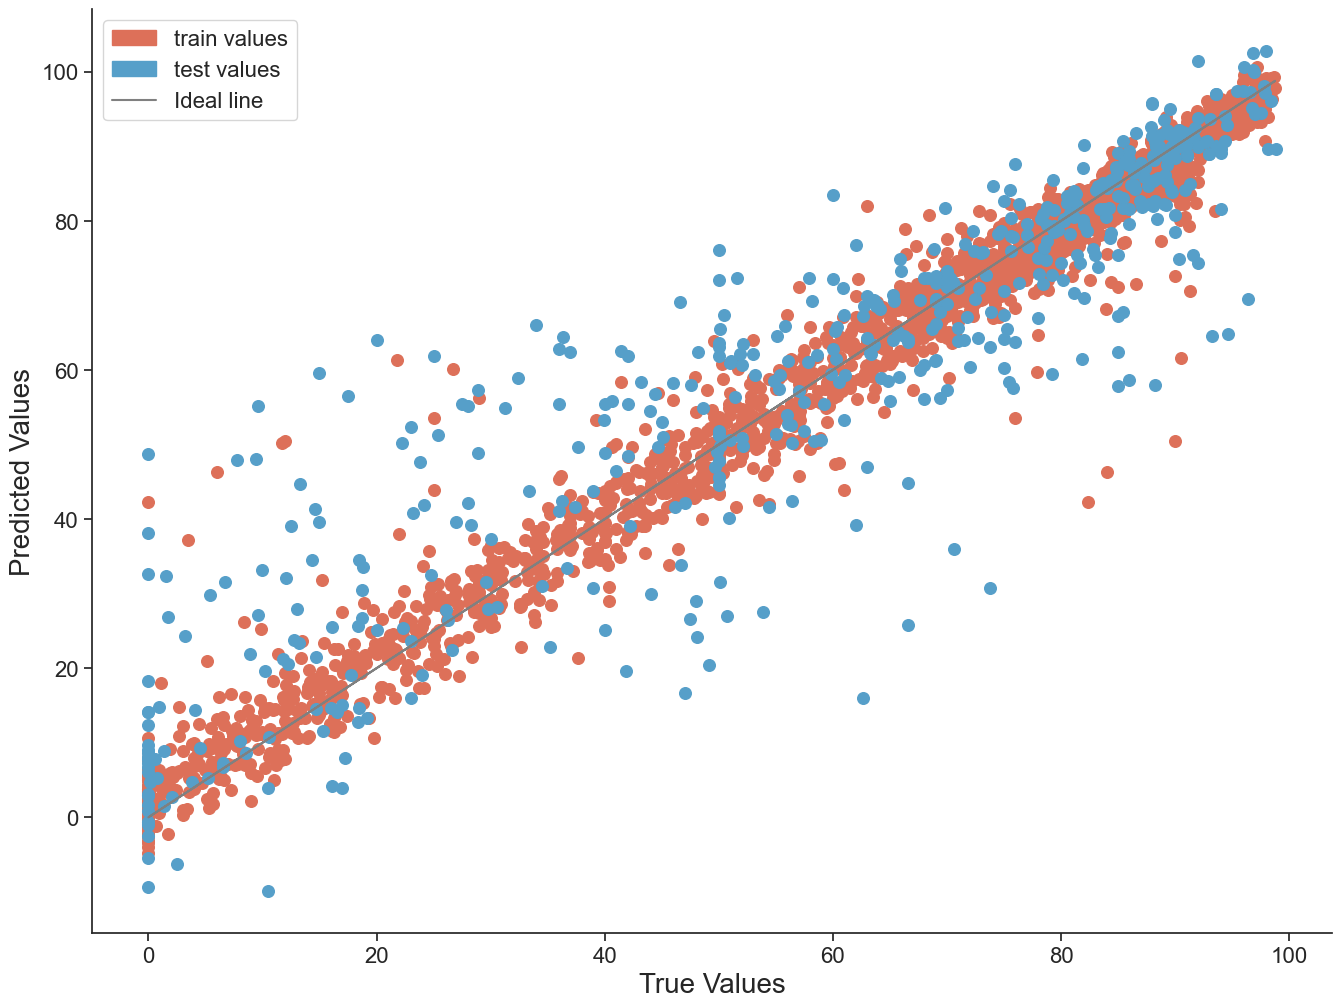

In [187]:

print(X.shape)
real_patch = Patch(color='#DD7059', label='train values')
pred_patch = Patch(color='#569FC9', label='test values')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
f, ax = plt.subplots(figsize=(16, 12))
plt.scatter(y, y_train_pred, color='#DD7059', s=70)
plt.scatter(y_test, y_pred, color='#569FC9',s=70)
plt.plot(y, y, color='gray')
plt.legend(handles=[real_patch, pred_patch, plt.Line2D([], [], color='gray', label='Ideal line')], fontsize=16)
plt.title('')
plt.xlabel('True Values', fontsize=20)
plt.ylabel('Predicted Values', fontsize=20)

plt.xticks(fontsize=16) # Увеличили размер шрифта делений оси Х
plt.yticks(fontsize=16)

plt.savefig('lgbm_tuned_metalearning.png')